<a href="https://colab.research.google.com/github/2103A52122/LogisticRegrforClassification/blob/main/Brain%20Disorder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [85]:
#import required libraries files
from tensorflow.keras.models import * #loading keras and tensorflow packages
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
import os
import numpy as np
from keras.utils import to_categorical
from keras.layers import  MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D, BatchNormalization
from keras.layers import Convolution2D
from keras.models import Sequential, load_model, Model
import pickle
from keras.applications import VGG16 #loaidng VGG16 model
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
import keras
from sklearn.metrics import accuracy_score #class to calculate accuracy and other metrics
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import seaborn as sns
import nibabel as nib
import cv2
import numpy as np
import keras
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard

In [101]:
dataset_path = "/content/drive/MyDrive/Dataset"
def getID(name): #function to get ID of the MRI view as label
    index = 0
    for i in range(len(labels)):
        if labels[i] == name:
            index = i
            break
    return index
#function to read labels from dataset
labels = []
for root, dirs, directory in os.walk(dataset_path):#now loop all files and get labels and then display all tumor names
    for j in range(len(directory)):
        name = os.path.basename(root)
        if name not in labels:
            labels.append(name)
print("Brain Tumor Classes Found in Dataset")
print(labels)

Brain Tumor Classes Found in Dataset
['notumor', 'pituitary', 'meningioma', 'glioma']


In [102]:
#now load dataset images
import os
if os.path.exists('model/X.txt.npy'):#if dataset already process then load load it
    X = np.load('model/X.txt.npy')
    Y = np.load('model/Y.txt.npy')
else: #if not process the loop all images from dataset
    X = []
    Y = []
    for root, dirs, directory in os.walk(dataset_path):#loop all images from dataset
        for j in range(len(directory)):
            name = os.path.basename(root)
            if 'Thumbs.db' not in directory[j]:
                img = cv2.imread(root+"/"+directory[j])#read images from looping path
                img = cv2.resize(img, (32,32))#resize images
                X.append(img)#add image features to X
                label = getID(name)#get Image ID
                Y.append(label) #add image id as label
    X = np.asarray(X)
    Y = np.asarray(Y)
    # Create the 'model' directory if it doesn't exist
    os.makedirs('model', exist_ok=True)
    np.save('model/X.txt',X)
    np.save('model/Y.txt',Y)
print("Dataset MRI Images Loading Completed")
print("Total images found in dataset : "+str(X.shape[0]))

Dataset MRI Images Loading Completed
Total images found in dataset : 5721


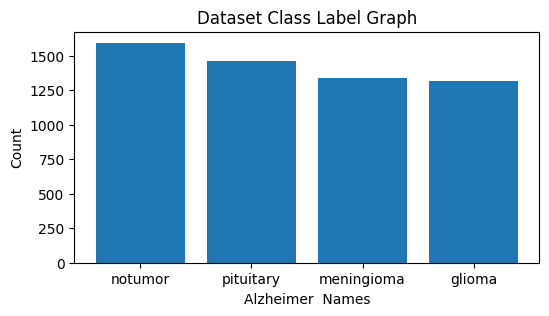

In [103]:
#plot graph of different labels found in dataset
unique, count = np.unique(Y, return_counts = True)
height = count
bars = labels
y_pos = np.arange(len(bars))
plt.figure(figsize=(6,3))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.xlabel("Alzheimer  Names")
plt.ylabel("Count")
plt.title("Dataset Class Label Graph")
plt.show()

In [104]:
#defining layers for 3D-UNET CNN model
def build_unet(inputs, ker_init, dropout):
    #defining conv3d cnn layer to build 3dunet
    conv1 = Conv3D(32, (3, 3, 3), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv3D(32, (3, 3, 3), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)

    pool = MaxPooling3D(pool_size=(2, 2, 2))(conv1)
    conv = Conv3D(64, (3, 3, 3), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv3D(64, (3, 3, 3), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv)
    conv2 = Conv3D(128, (3, 3, 3), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv3D(128, (3, 3, 3), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)

    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)
    conv3 = Conv3D(256, (3, 3, 3), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv3D(256, (3, 3, 3), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)


    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)
    conv5 = Conv3D(512, (3, 3, 3), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv3D(512, (3, 3, 3), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv3D(256, (2,2,2), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling3D(size = (2,2,2))(drop5))
    merge7 = concatenate([conv3,up7])
    conv7 = Conv3D(256, (3, 3, 3), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv3D(256, (3, 3, 3), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv3D(128, (2,2,2), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling3D(size = (2,2,2))(conv7))
    merge8 = concatenate([conv2,up8])
    conv8 = Conv3D(128, (3, 3, 3), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv3D(128, (3, 3, 3), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv3D(64, (2,2,2), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling3D(size = (2,2,2))(conv8))
    merge9 = concatenate([conv,up9])
    conv9 = Conv3D(64, (3, 3, 3), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv3D(64, (3, 3, 3), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)

    up = Conv3D(32, (2,2,2), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling3D(size = (2,2,2))(conv9))
    merge = concatenate([conv1,up])
    conv = Conv3D(32, (3, 3, 3), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv3D(32, (3, 3, 3), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    conv10 = Conv3D(4, (1,1,1), activation = 'softmax')(conv)

    return Model(inputs = inputs, outputs = conv10)

# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss

# define per class evaluation of dice coef
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)

# Computing Precision
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

# Computing Sensitivity
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [105]:
#create & load unet 3d model
input_layer = Input((128, 128, 128, 3))
unet_model = build_unet(input_layer, 'he_normal', 0.2)
# Train your model here, for example using:
# unet_model.fit(X_train, y_train, epochs=10, ...)
# Then save it:
# unet_model.save('model/model_per_class.h5') # Uncomment this line to save the model
# Finally, load it:
# If the model file does not exist, this line will raise a FileNotFoundError
# First train and save the model, then comment the previous 2 lines, and uncomment below to load the model.
# unet_model = keras.models.load_model('model/model_per_class.h5',custom_objects={ 'accuracy' : keras.metrics.MeanIoU(num_classes=4),
#                                                    "dice_coef": dice_coef,
#                                                    "precision": precision,
#                                                    "sensitivity":sensitivity,
#                                                    "specificity":specificity,
#                                                    "dice_coef_necrotic": dice_coef_necrotic,
#                                                    "dice_coef_edema": dice_coef_edema,
#                                                    "dice_coef_enhancing": dice_coef_enhancing
#                                                   }, compile=False)
unet_model.summary()

Model: "functional_97"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16            │ (None, 128, 128, 128,  │              0 │ -                      │
│ (InputLayer)              │ 3)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_92 (Conv3D)        │ (None, 128, 128, 128,  │          2,624 │ input_layer_16[0][0]   │
│                           │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_93 (Conv3D)        │ (None, 128, 128, 128,  │         27,680 │ conv3d_92[0][0]        │
│                           │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_16          │ (None, 64, 64, 64, 32) │              0 │ conv3d_93[0][0]        │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_94 (Conv3D)        │ (None, 64, 64, 64, 64) │         55,360 │ max_pooling3d_16[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_95 (Conv3D)        │ (None, 64, 64, 64, 64) │        110,656 │ conv3d_94[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_17          │ (None, 32, 32, 32, 64) │              0 │ conv3d_95[0][0]        │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_96 (Conv3D)        │ (None, 32, 32, 32,     │        221,312 │ max_pooling3d_17[0][0] │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_97 (Conv3D)        │ (None, 32, 32, 32,     │        442,496 │ conv3d_96[0][0]        │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_18          │ (None, 16, 16, 16,     │              0 │ conv3d_97[0][0]        │
│ (MaxPooling3D)            │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_98 (Conv3D)        │ (None, 16, 16, 16,     │        884,992 │ max_pooling3d_18[0][0] │
│                           │ 256)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_99 (Conv3D)        │ (None, 16, 16, 16,     │      1,769,728 │ conv3d_98[0][0]        │
│                           │ 256)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_19          │ (None, 8, 8, 8, 256)   │              0 │ conv3d_99[0][0]        │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_100 (Conv3D)       │ (None, 8, 8, 8, 512)   │      3,539,456 │ max_pooling3d_19[0][0] │
├──────────────────────

 Total params: 22,577,156 (86.13 MB)

 Trainable params: 22,577,156 (86.13 MB)

 Non-trainable params: 0 (0.00 B)

In [106]:
#dataset preprocessing such as shuffling and normalization
X = X.astype('float32')
X = X/255 #normalizing images
indices = np.arange(X.shape[0])
np.random.shuffle(indices)#shuffling images
X = X[indices]
Y = Y[indices]
Y = to_categorical(Y)
print("Dataset Normalization & Shuffling Process completed")

Dataset Normalization & Shuffling Process completed


In [107]:
#now splitting dataset into train & test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2) #split dataset into train and test
print()
print("Dataset train & test split as 80% dataset for training and 20% for testing")
print("Training Size (80%): "+str(X_train.shape[0])) #print training and test size
print("Testing Size (20%): "+str(X_test.shape[0]))
print()


Dataset train & test split as 80% dataset for training and 20% for testing
Training Size (80%): 4576
Testing Size (20%): 1145



In [108]:
#define global variables to calculate and store accuracy and other metrics
precision = []
recall = []
fscore = []
accuracy = []

In [109]:
#function to calculate various metrics such as accuracy, precision etc
def calculateMetrics(algorithm, predict, testY):
    p = precision_score(testY, predict,average='macro') * 100
    r = recall_score(testY, predict,average='macro') * 100
    f = f1_score(testY, predict,average='macro') * 100
    a = accuracy_score(testY,predict)*100
    print(algorithm+' Accuracy  : '+str(a))
    print(algorithm+' Precision   : '+str(p))
    print(algorithm+' Recall      : '+str(r))
    print(algorithm+' FMeasure    : '+str(f))
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    conf_matrix = confusion_matrix(testY, predict)
    plt.figure(figsize =(5, 4))
    ax = sns.heatmap(conf_matrix, xticklabels = labels, yticklabels = labels, annot = True, cmap="viridis" ,fmt ="g");
    ax.set_ylim([0,len(labels)])
    plt.title(algorithm+" Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 409ms/step
VGG16 Accuracy  : 87.68558951965065
VGG16 Precision   : 87.39101667078066
VGG16 Recall      : 87.40815464477019
VGG16 FMeasure    : 87.17228921866425


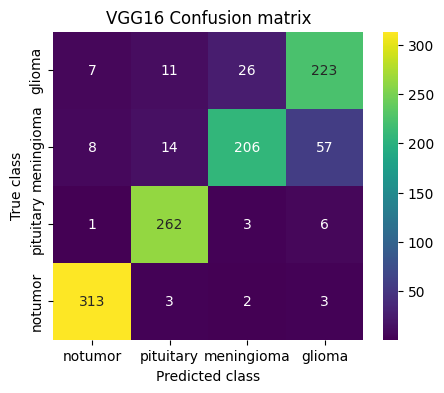

In [110]:
#train VGG16 on processed traion images
vgg16 = VGG16(input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]), include_top=False, weights='imagenet')
for layer in vgg16.layers:
    layer.trainable = False
vgg16_model = Sequential()
vgg16_model.add(vgg16)
vgg16_model.add(Convolution2D(32, (1 , 1), input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]), activation = 'relu'))
vgg16_model.add(MaxPooling2D(pool_size = (1, 1)))
vgg16_model.add(Convolution2D(32, (1, 1), activation = 'relu'))
vgg16_model.add(MaxPooling2D(pool_size = (1, 1)))
vgg16_model.add(Flatten())
vgg16_model.add(Dense(units = 256, activation = 'relu'))
vgg16_model.add(Dense(units = y_train.shape[1], activation = 'softmax'))
vgg16_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/vgg16_weights.keras") == False: # Changed the file extension to .keras
    model_check_point = ModelCheckpoint(filepath='model/vgg16_weights.keras', verbose = 1, save_best_only = True) # Changed the file extension to .keras
    hist = vgg16_model.fit(X, Y, batch_size = 32, epochs = 10, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/vgg16_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()
else:
    vgg16_model = load_model("model/vgg16_weights.keras") # Changed the file extension to .keras
#perform prediction on test images and then calculate accuracy and other metrics
predict = vgg16_model.predict(X_test)
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(y_test, axis=1)
calculateMetrics("VGG16", predict, y_test1)#call function to calculate accuracy and other metrics

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Proposed CNN Model Accuracy  : 93.01310043668121
Proposed CNN Model Precision   : 93.0641552281156
Proposed CNN Model Recall      : 92.93322030379548
Proposed CNN Model FMeasure    : 92.8463973332276


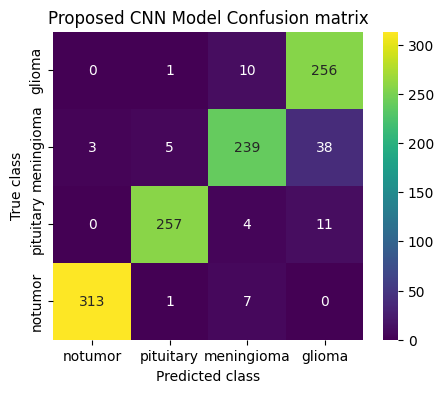

In [111]:
#training tensorflow, keras cnn proposed model
cnn_model = Sequential()
cnn_model.add(InputLayer(input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])))
cnn_model.add(Conv2D(64, (5, 5), activation='relu', strides=(1, 1), padding='same'))
cnn_model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
cnn_model.add(Conv2D(50, (5, 5), activation='relu', strides=(2, 2), padding='same'))
cnn_model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(70, (3, 3), activation='relu', strides=(2, 2), padding='same'))
cnn_model.add(MaxPool2D(pool_size=(2, 2), padding='valid'))
cnn_model.add(BatchNormalization())
cnn_model.add(Flatten())
cnn_model.add(Dense(units=100, activation='relu'))
cnn_model.add(Dense(units=100, activation='relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(units=y_train.shape[1], activation='softmax'))
cnn_model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
if os.path.exists("model/cnn_weights.keras") == False: # Changed the file extension to .keras
    model_check_point = ModelCheckpoint(filepath='model/cnn_weights.keras', verbose = 1, save_best_only = True) # Changed the file extension to .keras
    hist = cnn_model.fit(X_train, y_train, batch_size = 32, epochs = 10, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/cnn_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()
else:
    cnn_model.load_weights("model/cnn_weights.keras")  # Changed the file extension to .keras, but kept load_weights as it was used before
#perform prediction on test images and then calculate accuracy and other metrics
predict = cnn_model.predict(X_test)
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(y_test, axis=1)
calculateMetrics("Proposed CNN Model", predict, y_test1)#call function to calculate accuracy and other metrics

In [112]:
#classification report for each class
from sklearn.metrics import classification_report
print(classification_report(y_test1, predict, target_names=labels))

              precision    recall  f1-score   support

     notumor       0.99      0.98      0.98       321
   pituitary       0.97      0.94      0.96       272
  meningioma       0.92      0.84      0.88       285
      glioma       0.84      0.96      0.90       267

    accuracy                           0.93      1145
   macro avg       0.93      0.93      0.93      1145
weighted avg       0.93      0.93      0.93      1145



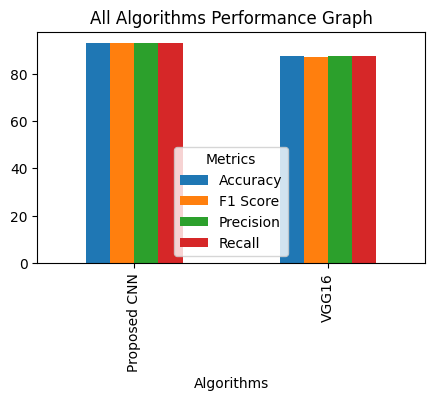

In [113]:
#comparison graph between all algorithms
import pandas as pd
df = pd.DataFrame([['VGG16','Precision',precision[0]],['VGG16','Recall',recall[0]],['VGG16','F1 Score',fscore[0]],['VGG16','Accuracy',accuracy[0]],
                   ['Proposed CNN','Precision',precision[1]],['Proposed CNN','Recall',recall[1]],['Proposed CNN','F1 Score',fscore[1]],['Proposed CNN','Accuracy',accuracy[1]],
                  ],columns=['Algorithms','Metrics','Value'])
df.pivot_table(index="Algorithms", columns="Metrics", values="Value").plot(kind='bar', figsize=(5, 3))
plt.title("All Algorithms Performance Graph")
plt.show()

In [114]:
#displaying all algorithms performance in tabular format
columns = ["Algorithm Name","Precison","Recall","FScore","Accuracy"]
values = []
algorithm_names = ["VGG16", "Proposed CNN"]
for i in range(len(algorithm_names)):
    values.append([algorithm_names[i],precision[i],recall[i],fscore[i],accuracy[i]])
temp = pd.DataFrame(values,columns=columns)
temp

,Algorithm Name,Precison,Recall,FScore,Accuracy
0,VGG16,87.391017,87.408155,87.172289,87.68559
1,Proposed CNN,93.064155,92.933220,92.846397,93.01310


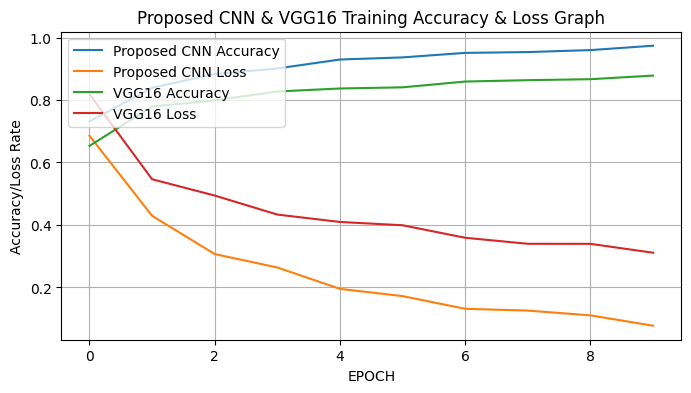

In [115]:
#function to plot accuracy and loss curve of all algorithms
f = open('model/cnn_history.pckl', 'rb')
data = pickle.load(f)
f.close()
cnn_accuracy = data['accuracy']
cnn_loss = data['loss']
f = open('model/vgg16_history.pckl', 'rb')
data = pickle.load(f)
f.close()
vgg_accuracy = data['accuracy']
vgg_loss = data['loss']
plt.figure(figsize=(8,4))
plt.grid(True)
plt.xlabel('EPOCH')
plt.ylabel('Accuracy/Loss Rate')
plt.plot(cnn_accuracy)
plt.plot(cnn_loss)
plt.plot(vgg_accuracy)
plt.plot(vgg_loss)
plt.legend(['Proposed CNN Accuracy', 'Proposed CNN Loss', 'VGG16 Accuracy', 'VGG16 Loss'], loc='upper left')
plt.title('Proposed CNN & VGG16 Training Accuracy & Loss Graph')
plt.show()

In [116]:
#function to convert image gto 3d format
def cv2_to_nibabel(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = cv2.resize(image, (128, 128))
    image = np.array(image)
    image = nib.Nifti1Image(image, affine=np.eye(4))
    return image

In [117]:
#unet function to read input image and then segment tumor
def getSegmentation(img_path):
    img = cv2.imread(img_path)
    # Convert the image to RGB if it's grayscale
    if len(img.shape) == 2:  # Check if the image is grayscale
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    # Resize the image to the expected input shape
    img = cv2.resize(img, (128, 128))
    # Create a 3D volume by replicating the 2D image along the z-axis
    img = np.stack([img] * 128, axis=0)  # Repeat the image 128 times
    # Reshape the image to add the batch dimension
    img = img.reshape(1, 128, 128, 128, 3)
    # Normalize the image
    img = img / 255.0
    # Now predict using the reshaped image
    data = unet_model.predict(img, verbose=1)
    core = data[:, :, :, :, 1]  # Adjust slicing for 5D output
    edema = data[:, :, :, :, 2]
    enhancing = data[:, :, :, :, 3]
    core = core[0]
    edema = edema[0]
    segment = enhancing[0]

    # Ensure the segment has only one channel before saving
    segment = segment.astype(np.uint8) # Convert to uint8
    segment = np.squeeze(segment) # Remove unnecessary dimensions if any
    # Check if the segment has more than 2 dimensions and if it has 3 or 4 channels
    if len(segment.shape) > 2 and segment.shape[-1] in (3, 4): # Check for 3 or 4 channels
        segment = cv2.cvtColor(segment, cv2.COLOR_BGR2GRAY) # convert it into grayscale
    elif len(segment.shape) > 2: # Handle cases with more than 2 dimensions but not 3 or 4 channels
        segment = segment[:,:,0] # Assuming the first channel is relevant

    cv2.imwrite("/content/drive/MyDrive/segment.jpg", segment)
    return cv2.imread("/content/drive/MyDrive/segment.jpg") # Return the segmented image

In [118]:
#function to classify and detect damage of brain tumor
def classifyTumor(test_image, image):
    img = cv2.imread(test_image)
    img = cv2.resize(img, (32,32))#resize image
    im2arr = np.array(img)
    im2arr = im2arr.reshape(1,32,32,3)
    img = np.asarray(im2arr)
    img = img.astype('float32')
    img = img/255 #normalizing test image
    predict = cnn_model.predict(img)#now using  cnn model to detcet tumor damage
    predict = np.argmax(predict)
    img = cv2.imread(test_image)
    img = cv2.resize(img, (600,400))
    image = cv2.resize(image, (600,400))
    cv2.putText(img, 'Prediction Output : '+labels[predict]+" Detected", (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (255, 0, 0), 2)
    cv2.putText(image, '3D-UNET Segmented Image', (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (255, 0, 0), 2)
    return img, image, labels[predict]

1/1 ━━━━━━━━━━━━━━━━━━━━ 32s 32s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


<Figure size 640x480 with 0 Axes>

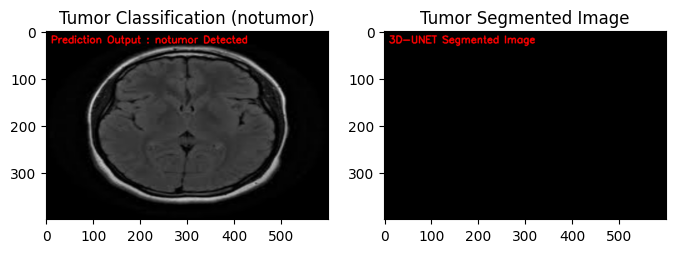

In [119]:
#input image to perform segmentation and then classify tumor damage
segmented_img = getSegmentation("/content/drive/MyDrive/testImages/6.jpg")
classify_img, segment, label = classifyTumor("/content/drive/MyDrive/testImages/6.jpg", segmented_img)
plt.figure()
f, axarr = plt.subplots(1,2, figsize=(8,4))
axarr[0].imshow(classify_img, cmap="gray")
axarr[0].title.set_text('Tumor Classification ('+label+")")
axarr[1].imshow(segment, cmap="gray")
axarr[1].title.set_text('Tumor Segmented Image')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 43s 43s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


<Figure size 640x480 with 0 Axes>

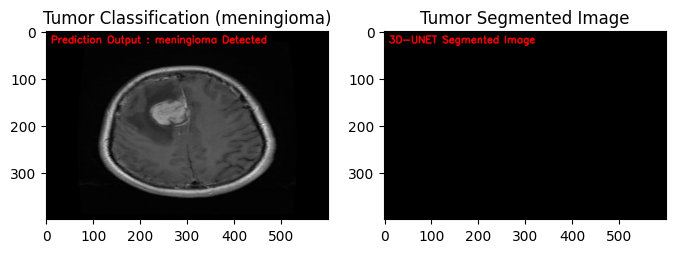

In [120]:
img = getSegmentation("/content/drive/MyDrive/testImages/4.jpg")
classify_img, segment, label = classifyTumor("/content/drive/MyDrive/testImages/4.jpg", img)
plt.figure()
f, axarr = plt.subplots(1,2, figsize=(8,4))
axarr[0].imshow(classify_img, cmap="gray")
axarr[0].title.set_text('Tumor Classification ('+label+")")
axarr[1].imshow(segment, cmap="gray")
axarr[1].title.set_text('Tumor Segmented Image')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 33s 33s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


<Figure size 640x480 with 0 Axes>

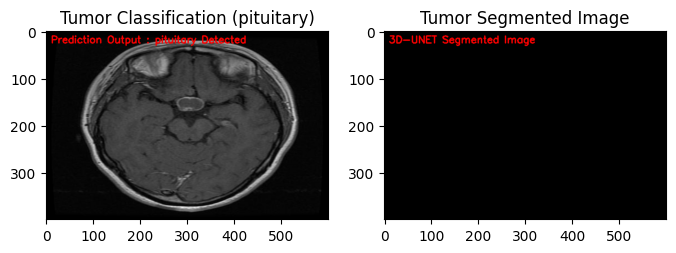

In [121]:
img = getSegmentation("/content/drive/MyDrive/testImages/8.jpg")
classify_img, segment, label = classifyTumor("/content/drive/MyDrive/testImages/8.jpg", img)
plt.figure()
f, axarr = plt.subplots(1,2, figsize=(8,4))
axarr[0].imshow(classify_img, cmap="gray")
axarr[0].title.set_text('Tumor Classification ('+label+")")
axarr[1].imshow(segment, cmap="gray")
axarr[1].title.set_text('Tumor Segmented Image')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 36s 36s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


<Figure size 640x480 with 0 Axes>

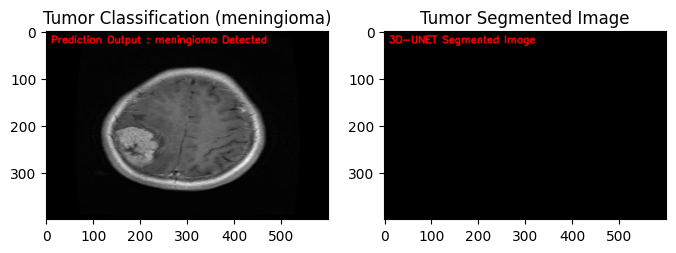

In [123]:
img = getSegmentation("/content/drive/MyDrive/testImages/3.jpg")
classify_img, segment, label = classifyTumor("/content/drive/MyDrive/testImages/3.jpg", img)
plt.figure()
f, axarr = plt.subplots(1,2, figsize=(8,4))
axarr[0].imshow(classify_img, cmap="gray")
axarr[0].title.set_text('Tumor Classification ('+label+")")
axarr[1].imshow(segment, cmap="gray")
axarr[1].title.set_text('Tumor Segmented Image')
plt.show()